In [1]:
import pickle
import numpy as np
with open(r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Python Skripte\calibration_results_thinlaser.pkl", "rb") as f:
    data = pickle.load(f)

df = data["df"]
mtx = data["mtx"]
dist = data["dist"]


In [2]:
def schnittpunkt_xAchsealt(x1, y1, x2, y2):
    delta_x = abs(x2 - x1)
    delta_y = abs(y2 - y1)
    m = delta_y / delta_x
    n = y1 - (x1 * m)
    sx = (-n-1080) / m
    return sx
def schnittpunkt_xAchse(x1, y1, x2, y2):
    """
    Berechnet den Schnittpunkt der Geraden durch (x1,y1)-(x2,y2)
    mit der x-Achse (y=0). Gibt die x-Koordinate zurück.
    """
    # Steigung m = (y2 - y1) / (x2 - x1)
    if x2 == x1:
        return np.inf  # vertikale Linie schneidet evtl. nie die x-Achse

    m = (y2 - y1) / (x2 - x1)
    n = y1 - m * x1  # Achsenabschnitt

    if m == 0:
        return np.inf  # horizontale Linie: kein Schnitt mit x-Achse

    sx = (+1080-n) / m  # dort, wo y=0 -> 0 = m*x + n
    return sx

points_right = []
points_left = []
#hier die punkte einteilen in links und rechts
# Spalten sicherstellen
if "points_left" not in df.columns:
    df["points_left"] = None
if "points_right" not in df.columns:
    df["points_right"] = None

# Spalten leeren (alte Werte entfernen)
df["points_left"] = None
df["points_right"] = None


for idx, row in df.iterrows():
    points = row["points"]
    path = row["path"]
    if points is None or len(points) < 4:
        continue  # keine gültigen Linien

    # Annahme: genau zwei Liniensegmente -> 2x(x1,y1,x2,y2)
    (x1, y1, x2, y2), (u1, v1, u2, v2) = np.array(points).reshape(-1, 4)

    sx1 = schnittpunkt_xAchse(x1, y1, x2, y2)
    sx2 = schnittpunkt_xAchse(u1, v1, u2, v2)
    print(f"punkte von bild: {path[-6:-1]}: ")

    if sx1 <= sx2:
        points_left = [(x1, y1), (x2, y2)]
        points_right = [(u1, v1), (u2, v2)]
    else:
        points_left = [(u1, v1), (u2, v2)]
        points_right = [(x1, y1), (x2, y2)]
    # Spalten sicherstellen

    # ins DataFrame schreiben
    df.at[idx, "points_left"] = points_left
    df.at[idx, "points_right"] = points_right


punkte von bild: 01.pn: 
punkte von bild: 02.pn: 
punkte von bild: 03.pn: 
punkte von bild: 04.pn: 
punkte von bild: 05.pn: 


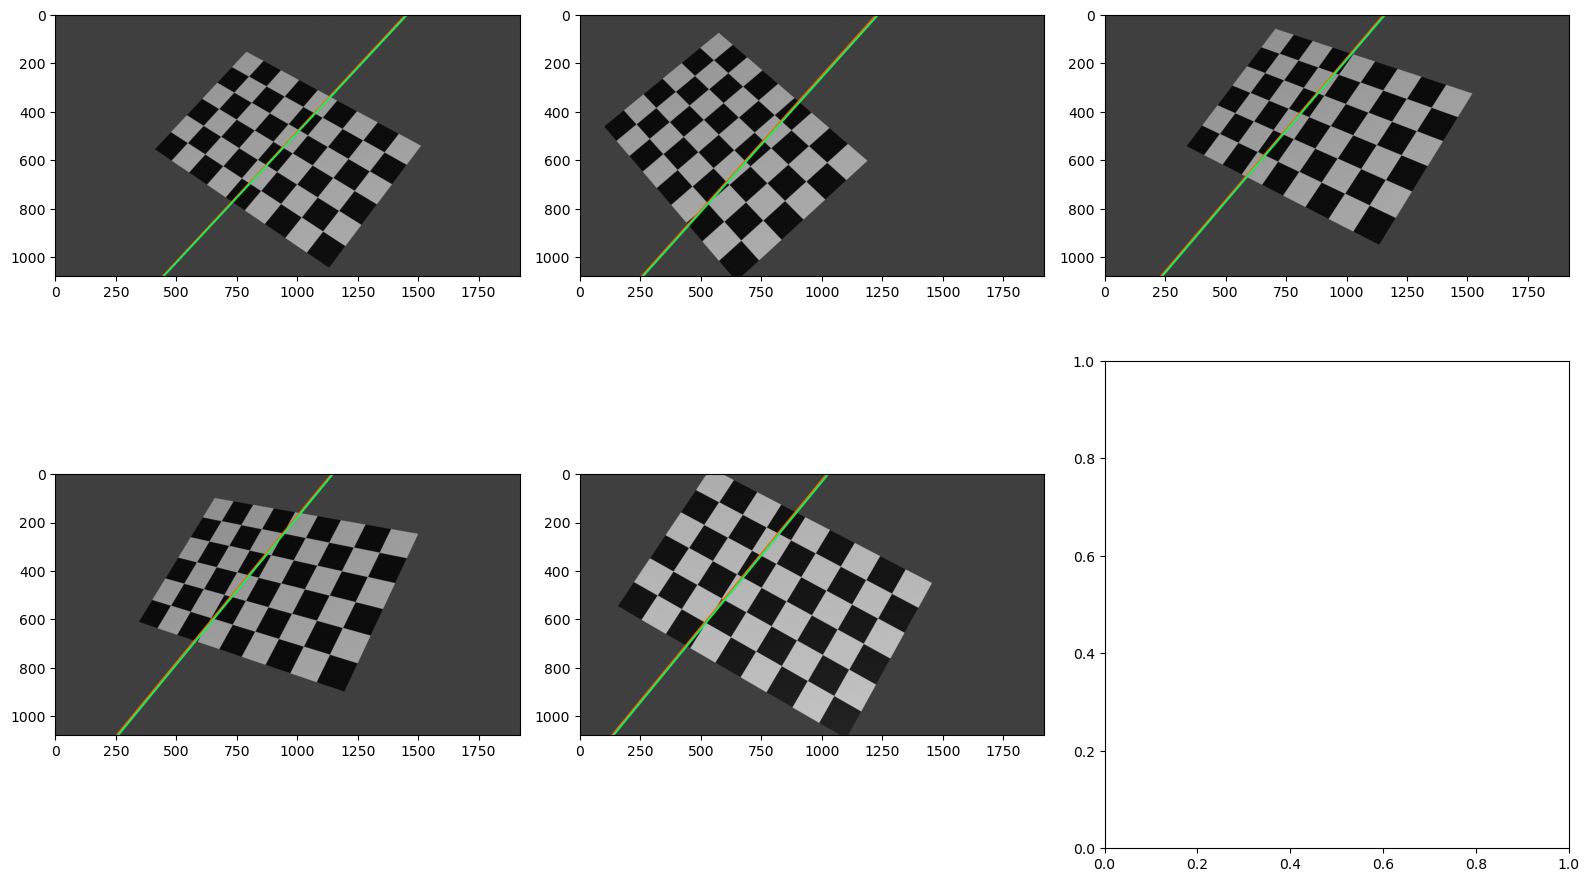

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
plt.close('all')
def extend_line(p1, p2, width, height):
    """Verlängert das Liniensegment über das gesamte Bild."""
    x1, y1 = p1
    x2, y2 = p2
    if x1 == x2:  # vertikale Linie
        return (x1, 0), (x1, height-1)
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    # Schnittpunkte mit linken und rechten Rand
    y_left = int(b)
    y_right = int(m * width + b)
    return (0, y_left), (width-1, y_right)
rows, cols = 2,3
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))  # Größe anpassfor idx, row in df.iterrows():
for ax, (_, row) in zip(axes.ravel(), df.iterrows()):
    path = row["path"]
    img = cv2.imread(path)
    h, w = img.shape[:2]
    points_left = row["points_left"]
    points_right = row["points_right"]
    if points_left and points_right is not None:
        l1, l2=extend_line(points_left[0], points_left[1], w, h)
        r1, r2=extend_line(points_right[0], points_right[1], w, h)
        cv2.line(img, l1, l2, (0, 100, 255), 5)
        cv2.line(img, r1, r2, (100, 255, 0), 5)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #ax.axis("off")
plt.tight_layout()
plt.show()
plt.close()


In [4]:
def pixel_to_cameraVector(u, v, K):
    pixelVector = np.array([u, v, 1])
    cameraVector = np.linalg.inv(K) @ (pixelVector )
    cameraVector = cameraVector / np.linalg.norm(cameraVector)
    return cameraVector
def get_normal_Checkerboard(rvec):
    #Normalenvektor des checkerboards ist aus R transformierte Z-Achse
    R, _ = cv2.Rodrigues(rvec)
    z= np.array([0, 0, 1])
    normal = R @ z
    return normal / np.linalg.norm(normal)
def get_intersection(cameraVector, tvec, normal):
    #Vereinfacht, da ursprung [0,0,0]
    lam = (normal @ tvec) / (normal @ cameraVector)
    P = lam * cameraVector
    return P
Plane_pointsR = []
Plane_pointsL = []

for idx, row in df.iterrows():
    for pts in [row["points_left"]]:
        if pts is None:
            continue
        for (u, v) in pts:
            tvec = row["translation"].reshape(3)
            rvec = row["rotation"].reshape(3)

            cam_vec = pixel_to_cameraVector(u, v, mtx)
            normal = get_normal_Checkerboard(rvec)
            P = get_intersection(cam_vec, tvec, normal)

            Plane_pointsR.append(P)
    for pts in [row["points_right"]]:
        if pts is None:
            continue
        for (u, v) in pts:
            tvec = row["translation"].reshape(3)
            rvec = row["rotation"].reshape(3)

            cam_vec = pixel_to_cameraVector(u, v, mtx)
            normal = get_normal_Checkerboard(rvec)
            P = get_intersection(cam_vec, tvec, normal)

            Plane_pointsL.append(P)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.close('all')
%matplotlib notebook

# --- Hilfsfunktion: Ebene via SVD fitten ---
def fit_plane_svd(points):
    centroid = np.mean(points, axis=0)
    _, _, vh = np.linalg.svd(points - centroid)
    normal = vh[-1, :]
    return centroid, normal / np.linalg.norm(normal)

# --- Hilfsfunktion: Ebene plotten ---
def plot_plane(ax, centroid, normal, color="orange", alpha=0.3, size=150):
    # Gitter im Bereich der Daten
    xx, yy = np.meshgrid(
        np.linspace(centroid[0]-size, centroid[0]+size, 10),
        np.linspace(centroid[1]-size, centroid[1]+size, 10)
    )
    # z aus Ebenengleichung
    zz = (-normal[0]*(xx - centroid[0]) - normal[1]*(yy - centroid[1]))/normal[2] + centroid[2]
    ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)

# --- Punkte vorbereiten ---
scanned_PointsR = np.asarray(Plane_pointsR, dtype=float).reshape(-1, 3)
scanned_PointsL = np.asarray(Plane_pointsL, dtype=float).reshape(-1, 3)

# --- Ebene fitten ---
centroid_L, normal_L = fit_plane_svd(scanned_PointsL)
centroid_R, normal_R = fit_plane_svd(scanned_PointsR)

# --- Plot ---
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1,1,1])

# Punkte
ax.scatter(scanned_PointsR[:,0], scanned_PointsR[:,1], scanned_PointsR[:,2], c='b', s=5, label="Right")
ax.scatter(scanned_PointsL[:,0], scanned_PointsL[:,1], scanned_PointsL[:,2], c='r', s=5, label="Left")

# Ebenen
plot_plane(ax, centroid_L, normal_L, color="red", alpha=0.25)
plot_plane(ax, centroid_R, normal_R, color="blue", alpha=0.25)

# Achsen skalieren
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    max_range = max([x_range, y_range, z_range]) / 2
    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)
    ax.set_xlim3d([x_middle - max_range, x_middle + max_range])
    ax.set_ylim3d([y_middle - max_range, y_middle + max_range])
    ax.set_zlim3d([z_middle - max_range, z_middle + max_range])

set_axes_equal(ax)

# Ansicht und Beschriftung
ax.view_init(elev=90, azim=-90)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

plt.show()

# --- Optional: Winkel zwischen Ebenen berechnen ---
angle = np.degrees(np.arccos(np.clip(np.dot(normal_L, normal_R), -1.0, 1.0)))
print(f"Winkel zwischen linker und rechter Ebene: {angle:.3f}°")


<IPython.core.display.Javascript object>

Winkel zwischen linker und rechter Ebene: 0.042°


In [35]:
import os
import pickle
import numpy as np

# ---------- Pfad zur bestehenden Datei ----------
save_path = r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Python Skripte\calibration_results_thinlaser.pkl"

# ---------- Datei laden ----------
with open(save_path, "rb") as f:
    data = pickle.load(f)

df = data["df"]
mtx = data["mtx"]
dist = data["dist"]

# ---------- Punktwolken vorbereiten ----------
scanned_PointsR = np.asarray(Plane_pointsR, dtype=float).reshape(-1, 3)
scanned_PointsL = np.asarray(Plane_pointsL, dtype=float).reshape(-1, 3)

# ---------- Ebene fitten (SVD) ----------
def fit_plane_svd(points):
    centroid = np.mean(points, axis=0)
    _, _, vh = np.linalg.svd(points - centroid)
    normal = vh[-1, :] / np.linalg.norm(vh[-1, :])
    return centroid, normal

centroid_L, normal_L = fit_plane_svd(scanned_PointsL)
centroid_R, normal_R = fit_plane_svd(scanned_PointsR)

# ---------- Dictionary erweitern ----------
data["plane_left"] = {
    "centroid": centroid_L,
    "normal": normal_L
}
data["plane_right"] = {
    "centroid": centroid_R,
    "normal": normal_R
}

# ---------- Aktualisiertes Dictionary speichern ----------
with open(save_path, "wb") as f:
    pickle.dump(data, f)

print("✅ Datei erfolgreich aktualisiert:")
print(f"   {save_path}")
print("\n📐 Ergebnisse:")
print("Left plane centroid:", centroid_L)
print("Left plane normal:  ", normal_L)
print("Right plane centroid:", centroid_R)
print("Right plane normal:  ", normal_R)


✅ Datei erfolgreich aktualisiert:
   G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Python Skripte\calibration_results_thinlaser.pkl

📐 Ergebnisse:
Left plane centroid: [-32.6168797   -7.4150206  473.99917136]
Left plane normal:   [ 0.70714668  0.4096605  -0.57630014]
Right plane centroid: [-31.30038261 -10.26521177 475.23444088]
Right plane normal:   [ 0.70742689  0.40900057 -0.57642495]
